# NLP

## Packages

In [11]:
# Loading packages 
import pandas as pd #for loading 
import nltk         #for natural language processing 
import gensim
import re           #regular expression 

## dowload all the corpus/methods from NTLK library that you will be using
nltk.download('wordnet') #lemmitization corpus 
nltk.download('omw-1.4') #for lemmitization otherwise you will get an error 
nltk.download('stopwords') #stopwords corpus
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jenniferdangguay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jenniferdangguay/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jenniferdangguay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jenniferdangguay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data set
We will load the dataset from the us we created in during data wrangling to analyse the risk description.

In [12]:
# Loading the dataset
us = pd.read_csv("/Users/jenniferdangguay/Documents/Mirror/School/School/KU/Winter 2022/Modern Data Analytics/Python/Project/Project mda/Draft/us.csv")

# There are 7 columns in the dataset
us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Unnamed: 0                               159 non-null    int64 
 1   Year                                     159 non-null    int64 
 2   State                                    159 non-null    object
 3   City                                     159 non-null    object
 4   Water security risk drivers              159 non-null    object
 5   Estimated magnitude of potential impact  159 non-null    object
 6   Risk description                         159 non-null    object
dtypes: int64(2), object(5)
memory usage: 8.8+ KB


In [13]:
#Let's have a glimpse of the dataset 
us.head(5)

,Unnamed: 0,Year,State,City,Water security risk drivers,Estimated magnitude of potential impact,Risk description
0,1,2021,GA,City of Atlanta,Higher water prices,Serious,The water cost burden is felt across all ZIP c...
1,17,2021,NY,New York City,Inadequate or ageing water supply infrastructure,Serious,New York City’s drinking water meets orexceeds...
2,31,2021,NV,City of Las Vegas,Increased water stress or scarcity,Extremely serious,"Lake Mead, which is 90% of Southern Nevada's s..."
3,35,2021,NV,City of Las Vegas,Increased water demand,Serious,Water costs are higher due to infrastructure c...
4,36,2021,NV,City of Las Vegas,Environmental regulations,Less serious,Water restrictions have led to more conservati...


Because we did not display all the rows, we might want to be sure the rows in the risk description variable all contain text. Therefore, we will check whether some rows do not contain text to analyse, and if so we will make sure these rows are removed before the text analysis.

In [14]:
# we can check how many rows miss "text" information
len(us[us["Risk description"].isna()])

0

As it turns out, there are no rows with missing text in the risk description variable.

Before analysing the text data, let's see the total number of text for each state in 2021. 

In [15]:
# Grouping by State, calculating the total number of risk descriptiion text for each State and arranging from descending order.
us.groupby(['State']).agg({'Risk description':'count'}).sort_values(by=['Risk description'], ascending=False)

,Risk description
State,
CA,49
NV,13
CO,10
TN,9
PA,9
UT,7
OH,6
FL,5
IN,5


It seems that **California**, **Colorado**, **Nevada**, **New Jersey**, **Utah** are most the states that are most threatened by water security problems in 2021 as caculated by the number of risk description pertaining to water security risk drivers. This is what we saw in the data wrangling/visualisation. 

We will therefore focus on post from California and Las Vegas. 

In [16]:
# Creating a subset of text dataset for the top 5 states 
top5 = us[us["State"].str.contains("CA|CO|NV|NJ|UT")]
top5.head(10)

,Unnamed: 0,Year,State,City,Water security risk drivers,Estimated magnitude of potential impact,Risk description
2,31,2021,NV,City of Las Vegas,Increased water stress or scarcity,Extremely serious,"Lake Mead, which is 90% of Southern Nevada's s..."
3,35,2021,NV,City of Las Vegas,Increased water demand,Serious,Water costs are higher due to infrastructure c...
4,36,2021,NV,City of Las Vegas,Environmental regulations,Less serious,Water restrictions have led to more conservati...
5,37,2021,NV,City of Las Vegas,Drought,Extremely serious,The City is currently experiencing a 20 year d...
6,38,2021,NV,City of Las Vegas,Energy supply issues,Less serious,"Due to the drought, there is less hydro capaci..."
7,46,2021,CA,City of Los Angeles,Increased water stress or scarcity,Serious,Historic drought; although the state-wide Cali...
8,47,2021,CA,City of Los Angeles,Inadequate or ageing water supply infrastructure,Serious,About one-fifth of the city's water pipes were...
10,63,2021,UT,City of Park City,Increased water stress or scarcity,Extremely serious,An increasing population coupled with increasi...
11,64,2021,UT,City of Park City,Drought,Serious,Park City meets the water needs of the communi...
13,226,2021,UT,Salt Lake City,Inadequate or ageing water supply infrastructure,Serious,"More rain, less snow, aging drainage systems, ..."


## Text cleaning and pre-processing

We will begin by answering the following questions: 

- How many risk descriptions do we have in the dataset? How many for each of the top 5 states in the US in 2021?
- What is the average number of words reported in the risk description by each of the top 5 states in the US in 2021?

In [17]:
# We will drop the following columns: Unnamed: 0, City, Estimated magnitude of potential impact comments, Water security risk drivers and Country
top5 = top5.drop(columns=['Unnamed: 0',
                                'City',
                                'Water security risk drivers', 
                                'Estimated magnitude of potential impact'])

In [18]:
#let's have a look a the new dataframe 
top5.head(7)

,Year,State,Risk description
2,2021,NV,"Lake Mead, which is 90% of Southern Nevada's s..."
3,2021,NV,Water costs are higher due to infrastructure c...
4,2021,NV,Water restrictions have led to more conservati...
5,2021,NV,The City is currently experiencing a 20 year d...
6,2021,NV,"Due to the drought, there is less hydro capaci..."
7,2021,CA,Historic drought; although the state-wide Cali...
8,2021,CA,About one-fifth of the city's water pipes were...


In [19]:
#To calculate the number of characters, we create a new column "word_count" to calculate the number of characters in each risk description
#To do this we will count the spaces but add one to calculate the number of words
top5['word_count'] = top5['Risk description'].str.count(' ') + 1

# Here's the structure of the final dataframe
top5.head(5)

,Year,State,Risk description,word_count
2,2021,NV,"Lake Mead, which is 90% of Southern Nevada's s...",53
3,2021,NV,Water costs are higher due to infrastructure c...,31
4,2021,NV,Water restrictions have led to more conservati...,31
5,2021,NV,The City is currently experiencing a 20 year d...,61
6,2021,NV,"Due to the drought, there is less hydro capaci...",23


In [20]:
# We can see longer sentences in the text column in jupyter notebook  
# We reset the "max_colwidth" in the pandas display options to display all characters in the text column.
pd.set_option("display.max_colwidth", None)

# Let's see the text with the most word count 
top5.sort_values(by='word_count', ascending=False).head(5)

,Year,State,Risk description,word_count
105,2018,CA,"From 2011 to 2017, California experienced its worst drought in 54 years. The drought was worsened by the effects of climate change reducing the Sierra snowpack, a vital stockpile of fresh water. In 2015, the Governor issued Executive Order B-29-15, proclaiming a continued state of emergency due to the ongoing drought and mandated that all Californians collectively reduce their potable water use by 25%. Later rules by the State Water Resources Control Board required the city to reduce its 2013 baseline use of potable water by 16%. Through the Cityâ€™s Water Conservation Plan, which outlined measures to achieve targeted water reductions at City facilities, the City was able to reduce its water use by 35%.In 2017, the Governor lifted the drought emergency for most of the state and asked Californians to continue using water responsibly and to make conservation a way of life. A report issued in February 2018 by the U.S. Drought Monitor, a project of government agencies and other partners, showed that 44% of the state, including Los Angeles County where Culver City resides, is now considered to be in a moderate drought.",187
57,2021,CA,"From 2011 to 2017, California experienced its worst drought in 54 years. The drought was worsened by the effects of climate change reducing the Sierra snowpack, a vital stockpile of freshwater. In 2015, the Governor issued Executive Order B-29-15, proclaiming a continued state of emergency due to the ongoing drought, and mandated that all Californians collectively reduce their potable water use by 25%. Later rules by the State Water Resources Control Board required the city to reduce its 2013 baseline use of potable water by 16%. Through the City’s Water Conservation Plan, which outlined measures to achieve targeted water reductions at City facilities, the City reduced its water use by 35%.In 2017, the Governor lifted the drought emergency for most of the state, and asked Californians to continue using water responsibly and to make conservation a way of life. The U.S. Drought Monitor, a project of government agencies and other partners, issued a report issued in February 2018 showing that 44% of the state, including Los Angeles County where Culver City resides, is now considered to be in a moderate drought.",181
136,2017,CA,"The State Water Project (SWP) has historically supplied 75% to 85% of the City's water from the Sacramento - San Joaquin Delta and the Solano Project (SP) has historically supplied 15% to 25% of the City's water from Lake Berryessa. Lake Herman has historically been used as an emergency water supply and temporary storage reservoir. The City has 3,100 acre-feet of reliable water supply and has purchased water from various agencies when needed. Allocations of water from the SWP have varied from 5% to 65%. When the allocation exceeded 35%, then the City had adequate water supply. Some of the SWP and SP water that is allocated and not used can be carried over or ""banked"" for use in future years. Approximately 10,000 acre-feet of water has been ""banked"" in Lake Berryessa for use during a drought. Reservoir storage is low - Lake Oroville is at 66% of Historical Average; Lake Berryessa is at lowest in 22 years, 76% of average.",163
93,2018,CA,"The State Water Project (SWP) has historically supplied 75% to 85% of the City's water from the Sacramento - San Joaquin Delta and the Solano Project (SP) has historically supplied 15% to 25% of the City's water from Lake Berryessa. Lake Herman has historically been used as an emergency water supply and temporary storage reservoir. The City has 3,100 acre-feet of reliable water supply and has purchased water from various agencies when needed. Allocations of water from the SWP have varied from 5% to 65%. When the allocation exceeded 35%, then the City had adequate water supply. Some of the SWP and SP water that is allocated and not used can be carried over or ""banked"" for use in future year

In [21]:
# Let's try to get summary statistics of the risk descriptions and answer the above sets of questions 
print("There are {} risk descriptions in the dataset:".format(top5.word_count.count()))
print("- California has {}".format(top5[(top5["State"] == "CA")].word_count.count()))
print("- Colorado has {}".format(top5[(top5["State"] == "CO")].word_count.count()))
print("- Nevada has {}".format(top5[(top5["State"] == "NV")].word_count.count()))
print("- New Jersey has {}".format(top5[(top5["State"] == "NJ")].word_count.count()))
print("- UT has {}\n".format(top5[(top5["State"] == "UT")].word_count.count()))

print("The average number of words in each risk description for California in 2021 is: {}\n".format(top5[(top5["State"] == "CA")].word_count.mean()))
print("The average number of words in each risk description for Colorado in 2021 is: {}\n".format(top5[(top5["State"] == "CO")].word_count.mean()))
print("The average number of words in each risk description for Nevada in 2021 is: {}\n".format(top5[(top5["State"] == "NV")].word_count.mean()))
print("The average number of words in each risk description for New Jersey in 2021 is: {}\n".format(top5[(top5["State"] == "NJ")].word_count.mean()))
print("The average number of words in each risk description for Utah in 2021 is: {}\n".format(top5[(top5["State"] == "UT")].word_count.mean()))

There are 84 risk descriptions in the dataset:
- California has 49
- Colorado has 10
- Nevada has 13
- New Jersey has 5
- UT has 7

The average number of words in each risk description for California in 2021 is: 51.183673469387756

The average number of words in each risk description for Colorado in 2021 is: 34.3

The average number of words in each risk description for Nevada in 2021 is: 48.46153846153846

The average number of words in each risk description for New Jersey in 2021 is: 27.0

The average number of words in each risk description for Utah in 2021 is: 30.571428571428573



## Removing hyperlinks

In the data cleaning, we will start by removing punctuations, non-text symbols, or hyper-links.

In [22]:
#first convert the text column into a list
top5df = top5["Risk description"].values.tolist()

# Here's how the raw text data looks like
top5df[5]

'Historic drought; although the state-wide California drought from 2014 to 2017 was recently declared over, the City anticipates being affected by future droughts. The California Governor has declared a drought for some areas of California in 2021. Although LA is not included, our water storage is dependent on future rainfall, which is not guaranteed. LA    is continuing public education and outreach on water conservation as a new way of life.'

In [23]:
# Removal of hyper-link
# function to remove hyperlink 
def link_removal(sentences):
    for sentence in sentences:
        yield(re.sub(r'http\S+','', str(sentence)))

top5df_nolink = list(link_removal(top5df))
top5df_nolink[5]

'Historic drought; although the state-wide California drought from 2014 to 2017 was recently declared over, the City anticipates being affected by future droughts. The California Governor has declared a drought for some areas of California in 2021. Although LA is not included, our water storage is dependent on future rainfall, which is not guaranteed. LA    is continuing public education and outreach on water conservation as a new way of life.'

## Remove punctuations, non-text symbols (e.g., numbers, hastags), tokenise and normalise

In [24]:
from gensim.utils import simple_preprocess

# We write a function to 1) tokenise sentences into words, and also 2) remove punctuations in the sentences 
def sent_to_words(sentences): 
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Now, let's apply the function to all the risk descriptions 
# You will find all punctuations (including emojis, hashtag, symbols, numbers) are removed from the sentence.
top5df_words = list(sent_to_words(top5df_nolink))

In [25]:
# Let see our pre-processing progress so far
exampledf_1 = pd.DataFrame(
    {'raw text': top5df,
     'removal of punctuations, tokenised, normalised': top5df_words
    })
exampledf_1.head(5)

,raw text,"removal of punctuations, tokenised, normalised"
0,"Lake Mead, which is 90% of Southern Nevada's supply, is currently less than 40% of capacity, and continues to decline. Southern Nevada Water Authority officials have also been studying and have water rights in Eastern Nevada and will develop a groundwater importation project (pipeline) in the event water levels continue to decline.","[lake, mead, which, is, of, southern, nevada, supply, is, currently, less, than, of, capacity, and, continues, to, decline, southern, nevada, water, authority, officials, have, also, been, studying, and, have, water, rights, in, eastern, nevada, and, will, develop, groundwater, importation, project, pipeline, in, the, event, water, levels, continue, to, decline]"
1,"Water costs are higher due to infrastructure charges used to pay for new water projects, such as the third intake at Lake Mead. Even with conservation efforts, water costs have increased.","[water, costs, are, higher, due, to, infrastructure, charges, used, to, pay, for, new, water, projects, such, as, the, third, intake, at, lake, mead, even, with, conservation, efforts, water, costs, have, increased]"
2,"Water restrictions have led to more conservation; however, if Lake Mead continues to decline, a Federally mandated cut in Southern Nevada's water allocation may occur, and nearly did during the 2015-2016.","[water, restrictions, have, led, to, more, conservation, however, if, lake, mead, continues, to, decline, federally, mandated, cut, in, southern, nevada, water, allocation, may, occur, and, nearly, did, during, the]"
3,"The City is currently experiencing a 20 year drought. According to climate scientists and SNWA, there is an 80 to 90 percentchance there will be another mutli-decade drought this century due to climate change. This hazard has the immediate effect of a shortfall of water supplies across all Colorado River water users; the long-term effect will also be economic and environmental","[the, city, is, currently, experiencing, year, drought, according, to, climate, scientists, and, snwa, there, is, an, to, percentchance, there, will, be, another, mutli, decade, drought, this, century, due, to, climate, change, this, hazard, has, the, immediate, effect, of, shortfall, of, water, supplies, across, all, colorado, river, water, users, the, long, term, effect, will, also, be, economic, and, environmental]"
4,"Due to the drought, there is less hydro capacity and generation at Hoover and Davis Dams as a result of lower water supplies.","[due, to, the, drought, there, is, less, hydro, capacity, and, generation, at, hoover, and, davis, dams, as, result, of, lower, water, supplies]"


## Stop words removal 

We will also filter stop words because they have little lexical content. 

The NTLK library support the removal of stop words and we will use the list of stop words found in the corpus of ````stopwords```` from the NTLK library.

In [26]:
# Importing NLTK stop words
from nltk.corpus import stopwords

In [27]:
#Let's see which stopwords are included in NLTK English stopwords corpus 
stopwords.words('english') 

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [28]:
#let's store the list of stopwords from the corpus into an object 
stop_words = stopwords.words('english') 

In [29]:
#function to filter out words that appear in the stopwords list from NLTK English stopwords library
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

#apply the stopwords filtering functions on tokenised and normalised risk description
top5df_words_nostopwords = remove_stopwords(top5df_words)

In [30]:
# Let's see our pre-processing progress so far
exampledf_2 = pd.DataFrame(
    {'raw text': top5df,
     'removal of punctuations, tokenised, normalised': top5df_words,
     'stop words removed': top5df_words_nostopwords
    })
exampledf_2.head(10)

,raw text,"removal of punctuations, tokenised, normalised",stop words removed
0,"Lake Mead, which is 90% of Southern Nevada's supply, is currently less than 40% of capacity, and continues to decline. Southern Nevada Water Authority officials have also been studying and have water rights in Eastern Nevada and will develop a groundwater importation project (pipeline) in the event water levels continue to decline.","[lake, mead, which, is, of, southern, nevada, supply, is, currently, less, than, of, capacity, and, continues, to, decline, southern, nevada, water, authority, officials, have, also, been, studying, and, have, water, rights, in, eastern, nevada, and, will, develop, groundwater, importation, project, pipeline, in, the, event, water, levels, continue, to, decline]","[lake, mead, southern, nevada, supply, currently, less, capacity, continues, decline, southern, nevada, water, authority, officials, also, studying, water, rights, eastern, nevada, develop, groundwater, importation, project, pipeline, event, water, levels, continue, decline]"
1,"Water costs are higher due to infrastructure charges used to pay for new water projects, such as the third intake at Lake Mead. Even with conservation efforts, water costs have increased.","[water, costs, are, higher, due, to, infrastructure, charges, used, to, pay, for, new, water, projects, such, as, the, third, intake, at, lake, mead, even, with, conservation, efforts, water, costs, have, increased]","[water, costs, higher, due, infrastructure, charges, used, pay, new, water, projects, third, intake, lake, mead, even, conservation, efforts, water, costs, increased]"
2,"Water restrictions have led to more conservation; however, if Lake Mead continues to decline, a Federally mandated cut in Southern Nevada's water allocation may occur, and nearly did during the 2015-2016.","[water, restrictions, have, led, to, more, conservation, however, if, lake, mead, continues, to, decline, federally, mandated, cut, in, southern, nevada, water, allocation, may, occur, and, nearly, did, during, the]","[water, restrictions, led, conservation, however, lake, mead, continues, decline, federally, mandated, cut, southern, nevada, water, allocation, may, occur, nearly]"
3,"The City is currently experiencing a 20 year drought. According to climate scientists and SNWA, there is an 80 to 90 percentchance there will be another mutli-decade drought this century due to climate change. This hazard has the immediate effect of a shortfall of water supplies across all Colorado River water users; the long-term effect will also be economic and environmental","[the, city, is, currently, experiencing, year, drought, according, to, climate, scientists, and, snwa, there, is, an, to, percentchance, there, will, be, another, mutli, decade, drought, this, century, due, to, climate, change, this, hazard, has, the, immediate, effect, of, shortfall, of, water, supplies, across, all, colorado, river, water, users, the, long, term, effect, will, also, be, economic, and, environmental]","[city, currently, experiencing, year, drought, according, climate, scientists, snwa, percentchance, another, mutli, decade, drought, century, due, climate, change, hazard, immediate, effect, shortfall, water, supplies, across, colorado, river, water, users, long, term, effect, also, economic, environmental]"
4,"Due to the drought, there is less hydro capacity and generation at Hoover and Davis Dams as a result of lower water supplies.","[due, to, the, drought, there, is, less, hydro, capacity, and, generation, at, hoover, and, davis, dams, as, result, of, lower, water, supplies]","[due, drought, less, hydro, capacity, generation, hoover, davis, dams, result, lower, water, supplies]"
5,"Historic drought; although the state-wide California drought from 2014 to 2017 was recently declared over, the City anticipates being affected by future droughts. The California Governor has declared a drought for some areas of California in 2021. Although LA is

## Lemmetisation

**Lemmetisation** and **stemming** both finds the root form of  a word, but unlike **stemming** it takes into account the knowledge of the context and therefore can better discriminate between words which have meanings depending on part of speech. While **lemmitisation** generally is computationally slowler than **stemming**, it produces more accurate results. Therefore, we will will use lemmatisation to reduce related forms of a word to a common base form. For this we will use the ````WordNet```` corpus from NTLK library.

In [31]:
# Python NLTK provides WordNet Lemmatizer that uses the WordNet Database to lookup lemmas of words.
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# define a function to lemmatize list of words 
def lemmatise(texts):
    return [[lemmatizer.lemmatize(word) for word in doc] for doc in texts]

#apply the function onto the previous nostopwords dataframe 
top5df_lemmatise = lemmatise(top5df_words_nostopwords)

In [32]:
# Let see our pre-processing progress so far
exampledf_3 = pd.DataFrame(
    {'raw text': top5df,
     'removal of punctuations, tokenised, normalised': top5df_words,
     'stop words removed': top5df_words_nostopwords,
     'lemmatised words':top5df_lemmatise 
    })
exampledf_3.head(10)

,raw text,"removal of punctuations, tokenised, normalised",stop words removed,lemmatised words
0,"Lake Mead, which is 90% of Southern Nevada's supply, is currently less than 40% of capacity, and continues to decline. Southern Nevada Water Authority officials have also been studying and have water rights in Eastern Nevada and will develop a groundwater importation project (pipeline) in the event water levels continue to decline.","[lake, mead, which, is, of, southern, nevada, supply, is, currently, less, than, of, capacity, and, continues, to, decline, southern, nevada, water, authority, officials, have, also, been, studying, and, have, water, rights, in, eastern, nevada, and, will, develop, groundwater, importation, project, pipeline, in, the, event, water, levels, continue, to, decline]","[lake, mead, southern, nevada, supply, currently, less, capacity, continues, decline, southern, nevada, water, authority, officials, also, studying, water, rights, eastern, nevada, develop, groundwater, importation, project, pipeline, event, water, levels, continue, decline]","[lake, mead, southern, nevada, supply, currently, le, capacity, continues, decline, southern, nevada, water, authority, official, also, studying, water, right, eastern, nevada, develop, groundwater, importation, project, pipeline, event, water, level, continue, decline]"
1,"Water costs are higher due to infrastructure charges used to pay for new water projects, such as the third intake at Lake Mead. Even with conservation efforts, water costs have increased.","[water, costs, are, higher, due, to, infrastructure, charges, used, to, pay, for, new, water, projects, such, as, the, third, intake, at, lake, mead, even, with, conservation, efforts, water, costs, have, increased]","[water, costs, higher, due, infrastructure, charges, used, pay, new, water, projects, third, intake, lake, mead, even, conservation, efforts, water, costs, increased]","[water, cost, higher, due, infrastructure, charge, used, pay, new, water, project, third, intake, lake, mead, even, conservation, effort, water, cost, increased]"
2,"Water restrictions have led to more conservation; however, if Lake Mead continues to decline, a Federally mandated cut in Southern Nevada's water allocation may occur, and nearly did during the 2015-2016.","[water, restrictions, have, led, to, more, conservation, however, if, lake, mead, continues, to, decline, federally, mandated, cut, in, southern, nevada, water, allocation, may, occur, and, nearly, did, during, the]","[water, restrictions, led, conservation, however, lake, mead, continues, decline, federally, mandated, cut, southern, nevada, water, allocation, may, occur, nearly]","[water, restriction, led, conservation, however, lake, mead, continues, decline, federally, mandated, cut, southern, nevada, water, allocation, may, occur, nearly]"
3,"The City is currently experiencing a 20 year drought. According to climate scientists and SNWA, there is an 80 to 90 percentchance there will be another mutli-decade drought this century due to climate change. This hazard has the immediate effect of a shortfall of water supplies across all Colorado River water users; the long-term effect will also be economic and environmental","[the, city, is, currently, experiencing, year, drought, according, to, climate, scientists, and, snwa, there, is, an, to, percentchance, there, will, be, another, mutli, decade, drought, this, century, due, to, climate, change, this, hazard, has, the, immediate, effect, of, shortfall, of, water, supplies, across, all, colorado, river, water, users, the, long, term, effect, will, also, be, economic, and, environmental]","[city, currently, experiencing, year, drought, according, climate, scientists, snwa, percentchance, another, mutli, decade, drought, century, due, climate, change, hazard, immediate, effect, shortfall, water, supplies, across, colorado, river, water, users, long, term, effect, also, economic, environmental]","[city, currently, experien

Some verbs haven't been converted (e.g., "increased" is still "increased" instead of "increase"). Therefore our lemmitization function did not do a good job at converting the words to its based form.

Since words can have multiple lemmas based on the meaning / context (i.e., a word can either be a noun or a verb), we can correct the function by specifying the correct ‘part-of-speech’ tag (POS tag) as the second argument to lemmatize().

In [33]:
#Let's update our lemmitization function as by the lemmatization to verbs and nouns

#define a function to lemmatize list of words, applying on verbs 
def lemmatise_v(texts):
    return [[lemmatizer.lemmatize(word, pos="v") for word in doc] for doc in texts]
    
#define a function to lemmatize list of words, applying on nouns
def lemmatise_n(texts):
    return [[lemmatizer.lemmatize(word, pos="n") for word in doc] for doc in texts]

top5df_lemmatise_v = lemmatise_v(top5df_words_nostopwords)
top5df_lemmatise_n = lemmatise_n(top5df_lemmatise_v)

In [34]:
# Let see if our lemmetization functions did a better job 
exampledf_4 = pd.DataFrame(
    {'raw text': top5df,
     'removal of punctuations, tokenised, normalised': top5df_words,
     'stop words removed': top5df_words_nostopwords,
     'lemmatised words': top5df_lemmatise, 
     'lemmatised words verbs only': top5df_lemmatise_v,
     'lemmatised words including nouns': top5df_lemmatise_n,
    })
exampledf_4.head(10)

,raw text,"removal of punctuations, tokenised, normalised",stop words removed,lemmatised words,lemmatised words verbs only,lemmatised words including nouns
0,"Lake Mead, which is 90% of Southern Nevada's supply, is currently less than 40% of capacity, and continues to decline. Southern Nevada Water Authority officials have also been studying and have water rights in Eastern Nevada and will develop a groundwater importation project (pipeline) in the event water levels continue to decline.","[lake, mead, which, is, of, southern, nevada, supply, is, currently, less, than, of, capacity, and, continues, to, decline, southern, nevada, water, authority, officials, have, also, been, studying, and, have, water, rights, in, eastern, nevada, and, will, develop, groundwater, importation, project, pipeline, in, the, event, water, levels, continue, to, decline]","[lake, mead, southern, nevada, supply, currently, less, capacity, continues, decline, southern, nevada, water, authority, officials, also, studying, water, rights, eastern, nevada, develop, groundwater, importation, project, pipeline, event, water, levels, continue, decline]","[lake, mead, southern, nevada, supply, currently, le, capacity, continues, decline, southern, nevada, water, authority, official, also, studying, water, right, eastern, nevada, develop, groundwater, importation, project, pipeline, event, water, level, continue, decline]","[lake, mead, southern, nevada, supply, currently, less, capacity, continue, decline, southern, nevada, water, authority, officials, also, study, water, right, eastern, nevada, develop, groundwater, importation, project, pipeline, event, water, level, continue, decline]","[lake, mead, southern, nevada, supply, currently, le, capacity, continue, decline, southern, nevada, water, authority, official, also, study, water, right, eastern, nevada, develop, groundwater, importation, project, pipeline, event, water, level, continue, decline]"
1,"Water costs are higher due to infrastructure charges used to pay for new water projects, such as the third intake at Lake Mead. Even with conservation efforts, water costs have increased.","[water, costs, are, higher, due, to, infrastructure, charges, used, to, pay, for, new, water, projects, such, as, the, third, intake, at, lake, mead, even, with, conservation, efforts, water, costs, have, increased]","[water, costs, higher, due, infrastructure, charges, used, pay, new, water, projects, third, intake, lake, mead, even, conservation, efforts, water, costs, increased]","[water, cost, higher, due, infrastructure, charge, used, pay, new, water, project, third, intake, lake, mead, even, conservation, effort, water, cost, increased]","[water, cost, higher, due, infrastructure, charge, use, pay, new, water, project, third, intake, lake, mead, even, conservation, efforts, water, cost, increase]","[water, cost, higher, due, infrastructure, charge, use, pay, new, water, project, third, intake, lake, mead, even, conservation, effort, water, cost, increase]"
2,"Water restrictions have led to more conservation; however, if Lake Mead continues to decline, a Federally mandated cut in Southern Nevada's water allocation may occur, and nearly did during the 2015-2016.","[water, restrictions, have, led, to, more, conservation, however, if, lake, mead, continues, to, decline, federally, mandated, cut, in, southern, nevada, water, allocation, may, occur, and, nearly, did, during, the]","[water, restrictions, led, conservation, however, lake, mead, continues, decline, federally, mandated, cut, southern, nevada, water, allocation, may, occur, nearly]","[water, restriction, led, conservation, however, lake, mead, continues, decline, federally, mandated, cut, southern, nevada, water, allocation, may, occur, nearly]","[water, restrictions, lead, conservation, however, lake, mead, continue, decline, federally, mandate, cut, southern, nevada, water, allocation, may, occur, nearly]","[water, restriction, lead, conservation, however, la

In [35]:
# take the top5df_lemmatise_n to be the the lemmatised data 
top5df_lemmatised = top5df_lemmatise_n

exampledf_4_updated = pd.DataFrame(
    {'raw text': top5df,
     'removal of punctuations, tokenised, normalised': top5df_words,
     'stop words removed': top5df_words_nostopwords,
     'lemmatised words': top5df_lemmatised, 
    })

exampledf_4_updated.head(10)

,raw text,"removal of punctuations, tokenised, normalised",stop words removed,lemmatised words
0,"Lake Mead, which is 90% of Southern Nevada's supply, is currently less than 40% of capacity, and continues to decline. Southern Nevada Water Authority officials have also been studying and have water rights in Eastern Nevada and will develop a groundwater importation project (pipeline) in the event water levels continue to decline.","[lake, mead, which, is, of, southern, nevada, supply, is, currently, less, than, of, capacity, and, continues, to, decline, southern, nevada, water, authority, officials, have, also, been, studying, and, have, water, rights, in, eastern, nevada, and, will, develop, groundwater, importation, project, pipeline, in, the, event, water, levels, continue, to, decline]","[lake, mead, southern, nevada, supply, currently, less, capacity, continues, decline, southern, nevada, water, authority, officials, also, studying, water, rights, eastern, nevada, develop, groundwater, importation, project, pipeline, event, water, levels, continue, decline]","[lake, mead, southern, nevada, supply, currently, le, capacity, continue, decline, southern, nevada, water, authority, official, also, study, water, right, eastern, nevada, develop, groundwater, importation, project, pipeline, event, water, level, continue, decline]"
1,"Water costs are higher due to infrastructure charges used to pay for new water projects, such as the third intake at Lake Mead. Even with conservation efforts, water costs have increased.","[water, costs, are, higher, due, to, infrastructure, charges, used, to, pay, for, new, water, projects, such, as, the, third, intake, at, lake, mead, even, with, conservation, efforts, water, costs, have, increased]","[water, costs, higher, due, infrastructure, charges, used, pay, new, water, projects, third, intake, lake, mead, even, conservation, efforts, water, costs, increased]","[water, cost, higher, due, infrastructure, charge, use, pay, new, water, project, third, intake, lake, mead, even, conservation, effort, water, cost, increase]"
2,"Water restrictions have led to more conservation; however, if Lake Mead continues to decline, a Federally mandated cut in Southern Nevada's water allocation may occur, and nearly did during the 2015-2016.","[water, restrictions, have, led, to, more, conservation, however, if, lake, mead, continues, to, decline, federally, mandated, cut, in, southern, nevada, water, allocation, may, occur, and, nearly, did, during, the]","[water, restrictions, led, conservation, however, lake, mead, continues, decline, federally, mandated, cut, southern, nevada, water, allocation, may, occur, nearly]","[water, restriction, lead, conservation, however, lake, mead, continue, decline, federally, mandate, cut, southern, nevada, water, allocation, may, occur, nearly]"
3,"The City is currently experiencing a 20 year drought. According to climate scientists and SNWA, there is an 80 to 90 percentchance there will be another mutli-decade drought this century due to climate change. This hazard has the immediate effect of a shortfall of water supplies across all Colorado River water users; the long-term effect will also be economic and environmental","[the, city, is, currently, experiencing, year, drought, according, to, climate, scientists, and, snwa, there, is, an, to, percentchance, there, will, be, another, mutli, decade, drought, this, century, due, to, climate, change, this, hazard, has, the, immediate, effect, of, shortfall, of, water, supplies, across, all, colorado, river, water, users, the, long, term, effect, will, also, be, economic, and, environmental]","[city, currently, experiencing, year, drought, according, climate, scientists, snwa, percentchance, another, mutli, decade, drought, century, due, climate, change, hazard, immediate, effect, shortfall, water, supplies, across, colorado, river, water, users, long, term, effect, also, economic, environmental]","[city, currently, experience, yea

Looks like our problem has been fixed - words have been reduced to their correct base stem. Thus, the updated lemmatization functions works correctly! 

## Named entity recognition (NER) and further POS tagging 

We can use ````spaCy```` to recognize various types of named entities in a document, specifically the states and cities we have in our risk descriptions (e.g., California, Colorado).

In [36]:
# Part-of-speech tag 
import spacy
from spacy import displacy

# part-of-speech tags for English 
nlp = spacy.load("en_core_web_sm")

In [37]:
# Named entities recognition
pos_example = nlp(top5df[20])
displacy.render(pos_example, style="ent", jupyter = True)

In [38]:
# We could further our corpus of words by using this library to do a post POS tagging on the lemmatized words 

# Getting the pipeline component
nlp = spacy.load("en_core_web_sm") 

# Function to create a post POS tag, allowing only nounds, adjectives, verbs, and adverbs in the corpus
def postags_filter(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Apply the function on the lemmatized words 
top5df_postag = postags_filter(top5df_lemmatised, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [39]:
# Let see our pre-processing progress so far
exampledf_5 = pd.DataFrame(
    {'raw text': top5df,
     'removal of punctuations, tokenised, normalised': top5df_words,
     'stop words removed': top5df_words_nostopwords,
     'lemmatised words': top5df_lemmatised,
     'pos tagged': top5df_postag
    })
exampledf_5.head(10)

,raw text,"removal of punctuations, tokenised, normalised",stop words removed,lemmatised words,pos tagged
0,"Lake Mead, which is 90% of Southern Nevada's supply, is currently less than 40% of capacity, and continues to decline. Southern Nevada Water Authority officials have also been studying and have water rights in Eastern Nevada and will develop a groundwater importation project (pipeline) in the event water levels continue to decline.","[lake, mead, which, is, of, southern, nevada, supply, is, currently, less, than, of, capacity, and, continues, to, decline, southern, nevada, water, authority, officials, have, also, been, studying, and, have, water, rights, in, eastern, nevada, and, will, develop, groundwater, importation, project, pipeline, in, the, event, water, levels, continue, to, decline]","[lake, mead, southern, nevada, supply, currently, less, capacity, continues, decline, southern, nevada, water, authority, officials, also, studying, water, rights, eastern, nevada, develop, groundwater, importation, project, pipeline, event, water, levels, continue, decline]","[lake, mead, southern, nevada, supply, currently, le, capacity, continue, decline, southern, nevada, water, authority, official, also, study, water, right, eastern, nevada, develop, groundwater, importation, project, pipeline, event, water, level, continue, decline]","[currently, le, capacity, continue, decline, official, also, study, water, develop, groundwater, importation, project, pipeline, event, water, level, continue, decline]"
1,"Water costs are higher due to infrastructure charges used to pay for new water projects, such as the third intake at Lake Mead. Even with conservation efforts, water costs have increased.","[water, costs, are, higher, due, to, infrastructure, charges, used, to, pay, for, new, water, projects, such, as, the, third, intake, at, lake, mead, even, with, conservation, efforts, water, costs, have, increased]","[water, costs, higher, due, infrastructure, charges, used, pay, new, water, projects, third, intake, lake, mead, even, conservation, efforts, water, costs, increased]","[water, cost, higher, due, infrastructure, charge, use, pay, new, water, project, third, intake, lake, mead, even, conservation, effort, water, cost, increase]","[water, cost, high, due, infrastructure, charge, use, pay, new, water, project, lake, mead, even, conservation, effort, water, cost, increase]"
2,"Water restrictions have led to more conservation; however, if Lake Mead continues to decline, a Federally mandated cut in Southern Nevada's water allocation may occur, and nearly did during the 2015-2016.","[water, restrictions, have, led, to, more, conservation, however, if, lake, mead, continues, to, decline, federally, mandated, cut, in, southern, nevada, water, allocation, may, occur, and, nearly, did, during, the]","[water, restrictions, led, conservation, however, lake, mead, continues, decline, federally, mandated, cut, southern, nevada, water, allocation, may, occur, nearly]","[water, restriction, lead, conservation, however, lake, mead, continue, decline, federally, mandate, cut, southern, nevada, water, allocation, may, occur, nearly]","[water, restriction, lead, conservation, however, continue, decline, federally, mandate, cut, allocation, occur, nearly]"
3,"The City is currently experiencing a 20 year drought. According to climate scientists and SNWA, there is an 80 to 90 percentchance there will be another mutli-decade drought this century due to climate change. This hazard has the immediate effect of a shortfall of water supplies across all Colorado River water users; the long-term effect will also be economic and environmental","[the, city, is, currently, experiencing, year, drought, according, to, climate, scientists, and, snwa, there, is, an, to, percentchance, there, will, be, another, mutli, decade, drought, this, century, due, to, climate, change, this, hazard, has, the, immediate, effect, of, shortfall, of, water, supplies, across, all

Notice that some words such as "city" and "lake" were not tagged correctly to be removed. For instance the "city" in "Park City" or lake in "Great Salt lake". Therefore we will extend the stop words function so that these words can be removed manually form the corpus of words. 

In [40]:
#tag "city", "lake", "park", "county", "Longmont" to be removed as a stop word 
stop_words.extend(['le', 'great', 'salt', 'city', 'lake', 'park', 'county','Longmont', 'mead'])

#Refresh the stop word function 
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

#apply the stopword function but this time on the post POS tag 
top5df_clean = remove_stopwords(top5df_postag)

In [55]:
# Let see our pre-processing progress so far
exampledf_6 = pd.DataFrame(
    {'raw text': top5df,
     'removal of punctuations, tokenised, normalised': top5df_words,
     'stop words removed': top5df_words_nostopwords,
     'lemmatised words': top5df_lemmatised,
     'pos tagged': top5df_postag,
     'clean text':top5df_clean
    })
exampledf_6

,raw text,"removal of punctuations, tokenised, normalised",stop words removed,lemmatised words,pos tagged,clean text
0,"Lake Mead, which is 90% of Southern Nevada's supply, is currently less than 40% of capacity, and continues to decline. Southern Nevada Water Authority officials have also been studying and have water rights in Eastern Nevada and will develop a groundwater importation project (pipeline) in the event water levels continue to decline.","[lake, mead, which, is, of, southern, nevada, supply, is, currently, less, than, of, capacity, and, continues, to, decline, southern, nevada, water, authority, officials, have, also, been, studying, and, have, water, rights, in, eastern, nevada, and, will, develop, groundwater, importation, project, pipeline, in, the, event, water, levels, continue, to, decline]","[lake, mead, southern, nevada, supply, currently, less, capacity, continues, decline, southern, nevada, water, authority, officials, also, studying, water, rights, eastern, nevada, develop, groundwater, importation, project, pipeline, event, water, levels, continue, decline]","[lake, mead, southern, nevada, supply, currently, le, capacity, continue, decline, southern, nevada, water, authority, official, also, study, water, right, eastern, nevada, develop, groundwater, importation, project, pipeline, event, water, level, continue, decline]","[currently, le, capacity, continue, decline, official, also, study, water, develop, groundwater, importation, project, pipeline, event, water, level, continue, decline]","[currently, capacity, continue, decline, official, also, study, water, develop, groundwater, importation, project, pipeline, event, water, level, continue, decline]"
1,"Water costs are higher due to infrastructure charges used to pay for new water projects, such as the third intake at Lake Mead. Even with conservation efforts, water costs have increased.","[water, costs, are, higher, due, to, infrastructure, charges, used, to, pay, for, new, water, projects, such, as, the, third, intake, at, lake, mead, even, with, conservation, efforts, water, costs, have, increased]","[water, costs, higher, due, infrastructure, charges, used, pay, new, water, projects, third, intake, lake, mead, even, conservation, efforts, water, costs, increased]","[water, cost, higher, due, infrastructure, charge, use, pay, new, water, project, third, intake, lake, mead, even, conservation, effort, water, cost, increase]","[water, cost, high, due, infrastructure, charge, use, pay, new, water, project, lake, mead, even, conservation, effort, water, cost, increase]","[water, cost, high, due, infrastructure, charge, use, pay, new, water, project, even, conservation, effort, water, cost, increase]"
2,"Water restrictions have led to more conservation; however, if Lake Mead continues to decline, a Federally mandated cut in Southern Nevada's water allocation may occur, and nearly did during the 2015-2016.","[water, restrictions, have, led, to, more, conservation, however, if, lake, mead, continues, to, decline, federally, mandated, cut, in, southern, nevada, water, allocation, may, occur, and, nearly, did, during, the]","[water, restrictions, led, conservation, however, lake, mead, continues, decline, federally, mandated, cut, southern, nevada, water, allocation, may, occur, nearly]","[water, restriction, lead, conservation, however, lake, mead, continue, decline, federally, mandate, cut, southern, nevada, water, allocation, may, occur, nearly]","[water, restriction, lead, conservation, however, continue, decline, federally, mandate, cut, allocation, occur, nearly]","[water, restriction, lead, conservation, however, continue, decline, federally, mandate, cut, allocation, occur, nearly]"
3,"The City is currently experiencing a 20 year drought. According to climate scientists and SNWA, there is an 80 to 90 percentchance there will be another mutli-decade drought this century due to climate change. This hazard has the immediate effect of a shortfall of w

# Text Analysis 

In [42]:
# Create Corpus for TF-IDF analysis 
top5["text_cleaned"] =  top5df_clean# Use the data_lemmatized for text analysis
top5["word_count_cleaned"] = top5["text_cleaned"].str.len()
top5.head(5)

,Year,State,Risk description,word_count,text_cleaned,word_count_cleaned
2,2021,NV,"Lake Mead, which is 90% of Southern Nevada's supply, is currently less than 40% of capacity, and continues to decline. Southern Nevada Water Authority officials have also been studying and have water rights in Eastern Nevada and will develop a groundwater importation project (pipeline) in the event water levels continue to decline.",53,"[currently, capacity, continue, decline, official, also, study, water, develop, groundwater, importation, project, pipeline, event, water, level, continue, decline]",18
3,2021,NV,"Water costs are higher due to infrastructure charges used to pay for new water projects, such as the third intake at Lake Mead. Even with conservation efforts, water costs have increased.",31,"[water, cost, high, due, infrastructure, charge, use, pay, new, water, project, even, conservation, effort, water, cost, increase]",17
4,2021,NV,"Water restrictions have led to more conservation; however, if Lake Mead continues to decline, a Federally mandated cut in Southern Nevada's water allocation may occur, and nearly did during the 2015-2016.",31,"[water, restriction, lead, conservation, however, continue, decline, federally, mandate, cut, allocation, occur, nearly]",13
5,2021,NV,"The City is currently experiencing a 20 year drought. According to climate scientists and SNWA, there is an 80 to 90 percentchance there will be another mutli-decade drought this century due to climate change. This hazard has the immediate effect of a shortfall of water supplies across all Colorado River water users; the long-term effect will also be economic and environmental",61,"[currently, experience, year, drought, accord, climate, percentchance, decade, drought, century, due, climate, change, hazard, immediate, effect, shortfall, water, supply, water, user, long, term, effect, also, economic, environmental]",27
6,2021,NV,"Due to the drought, there is less hydro capacity and generation at Hoover and Davis Dams as a result of lower water supplies.",23,"[due, drought, capacity, generation, hoover, result, low, water, supply]",9


````FreqDist()```` for calculating frequency distributions

In [43]:
# We used NLTK's FreqDist to find the most common words in the corpora
from nltk.probability import FreqDist

# We merged all pre-processed social media content from SNP into one corpora
corpora = top5['text_cleaned'].sum()

# And displayed the top 20 most common terms in the corpora
fdist = FreqDist(corpora)
top20words = fdist.most_common(20)

print("20 most common words after filtering:", fdist.most_common(20))

20 most common words after filtering: [('water', 188), ('drought', 85), ('year', 34), ('supply', 32), ('use', 30), ('increase', 30), ('continue', 23), ('state', 21), ('level', 17), ('impact', 17), ('conservation', 16), ('due', 14), ('future', 14), ('project', 13), ('reduce', 13), ('resource', 13), ('experience', 12), ('decline', 11), ('climate', 11), ('system', 11)]


In [44]:
#Let's create a data frame to nicely visualise the 20 words 
top20words = pd.DataFrame(top20words)
top20words.columns = ['words','count']
top20words.set_index('words',inplace=True)
top20words

,count
words,
water,188
drought,85
year,34
supply,32
use,30
increase,30
continue,23
state,21
level,17


In [45]:
# Let's see the 20 top ranked words *WITHOUT* text cleaning
corpora_uncleaned =  exampledf_5['removal of punctuations, tokenised, normalised'].sum()
fdist_uncleaned = FreqDist(corpora_uncleaned)
top20uncleaned = fdist_uncleaned.most_common(20)

print("20 most common words after filtering:", fdist_uncleaned.most_common(20))

20 most common words after filtering: [('water', 197), ('the', 195), ('and', 141), ('of', 126), ('to', 113), ('drought', 85), ('in', 81), ('is', 55), ('has', 43), ('city', 39), ('from', 36), ('for', 34), ('supply', 27), ('state', 27), ('that', 27), ('lake', 26), ('as', 25), ('have', 24), ('california', 24), ('be', 23)]


In [46]:
#Let's create a data frame to nicely visualise the 20 words 
top20uncleaned = pd.DataFrame(top20uncleaned)
top20uncleaned.columns = ['words','count']
top20uncleaned.set_index('words',inplace=True)
top20uncleaned

,count
words,
water,197
the,195
and,141
of,126
to,113
drought,85
in,81
is,55
has,43


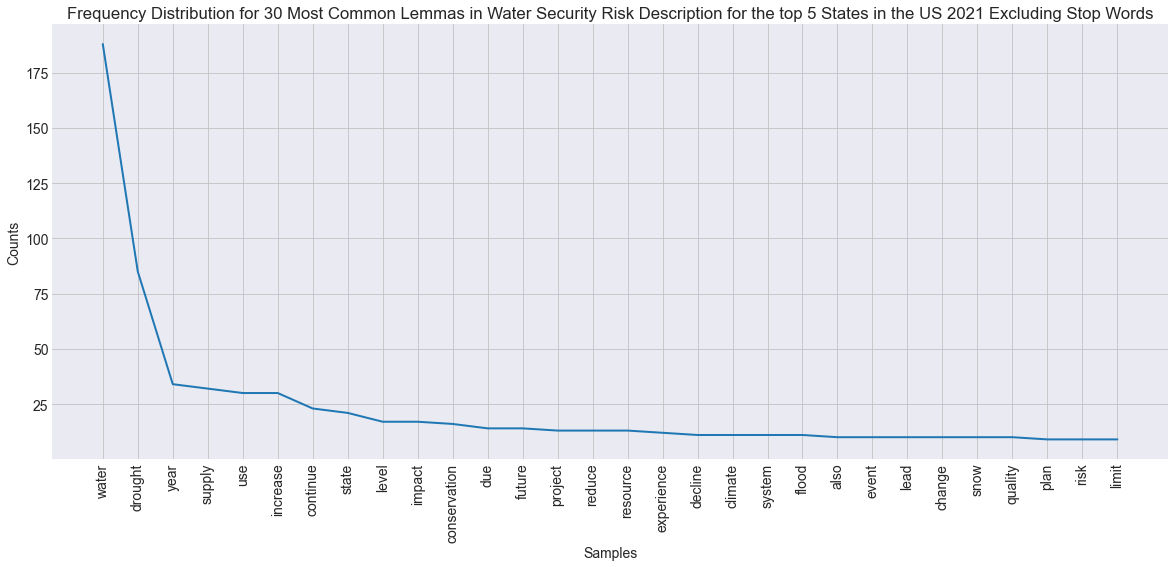

In [47]:
#load libraries for graphs 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use(['seaborn-dark'])

#plot the 30 most common lemmas from the clean corpus 
plt.figure(figsize = (20, 8))
plt.rc('font', size = 14)
number_of_tokens = 30 

fdist.plot(30, title='Frequency Distribution for '+str(number_of_tokens)+" Most Common Lemmas in Water Security Risk Description for the top 5 States in the US 2021 Excluding Stop Words",)

plt.show()

n-grams 

In [122]:
bigrams_list = list(nltk.bigrams(exampledf_5['removal of punctuations, tokenised, normalised'].sum()))
print(bigrams_list[:100]) #prints of the first 100 bigrams 

[('lake', 'mead'), ('mead', 'which'), ('which', 'is'), ('is', 'of'), ('of', 'southern'), ('southern', 'nevada'), ('nevada', 'supply'), ('supply', 'is'), ('is', 'currently'), ('currently', 'less'), ('less', 'than'), ('than', 'of'), ('of', 'capacity'), ('capacity', 'and'), ('and', 'continues'), ('continues', 'to'), ('to', 'decline'), ('decline', 'southern'), ('southern', 'nevada'), ('nevada', 'water'), ('water', 'authority'), ('authority', 'officials'), ('officials', 'have'), ('have', 'also'), ('also', 'been'), ('been', 'studying'), ('studying', 'and'), ('and', 'have'), ('have', 'water'), ('water', 'rights'), ('rights', 'in'), ('in', 'eastern'), ('eastern', 'nevada'), ('nevada', 'and'), ('and', 'will'), ('will', 'develop'), ('develop', 'groundwater'), ('groundwater', 'importation'), ('importation', 'project'), ('project', 'pipeline'), ('pipeline', 'in'), ('in', 'the'), ('the', 'event'), ('event', 'water'), ('water', 'levels'), ('levels', 'continue'), ('continue', 'to'), ('to', 'decline')

In [134]:
fbigrams_list = FreqDist(bigrams_list)
top20bigrams = fbigrams_list.most_common(20)

top20bigrams = pd.DataFrame(top20bigrams)
top20bigrams.columns = ['Bigram','Count']
top20bigrams.set_index('Bigram',inplace=True)
top20bigrams

,Count
Bigram,
"(of, the)",32
"(the, city)",29
"(in, the)",26
"(the, state)",23
"(water, supply)",19
"(the, drought)",17
"(due, to)",14
"(lake, mead)",13
"(of, water)",13


In [131]:
bigrams_list2 = list(nltk.bigrams(exampledf_6['clean text'].sum()))
print(bigrams_list2[:100]) #prints of the first 100 bigrams 

[('currently', 'capacity'), ('capacity', 'continue'), ('continue', 'decline'), ('decline', 'official'), ('official', 'also'), ('also', 'study'), ('study', 'water'), ('water', 'develop'), ('develop', 'groundwater'), ('groundwater', 'importation'), ('importation', 'project'), ('project', 'pipeline'), ('pipeline', 'event'), ('event', 'water'), ('water', 'level'), ('level', 'continue'), ('continue', 'decline'), ('decline', 'water'), ('water', 'cost'), ('cost', 'high'), ('high', 'due'), ('due', 'infrastructure'), ('infrastructure', 'charge'), ('charge', 'use'), ('use', 'pay'), ('pay', 'new'), ('new', 'water'), ('water', 'project'), ('project', 'even'), ('even', 'conservation'), ('conservation', 'effort'), ('effort', 'water'), ('water', 'cost'), ('cost', 'increase'), ('increase', 'water'), ('water', 'restriction'), ('restriction', 'lead'), ('lead', 'conservation'), ('conservation', 'however'), ('however', 'continue'), ('continue', 'decline'), ('decline', 'federally'), ('federally', 'mandate'

In [132]:
#get the top20 bigrams from the clean text 
fbigrams_list2 = FreqDist(bigrams_list2)

#let's create a table for the bigrams 
top20bigrams_df = pd.DataFrame(fbigrams_list2.most_common(20))
#change column names
top20bigrams_df.columns = ['Words','Count']

top20bigrams_df

,Words,Count
0,"(water, supply)",23
1,"(year, drought)",12
2,"(water, use)",12
3,"(water, resource)",11
4,"(continue, decline)",9
5,"(climate, change)",9
6,"(water, conservation)",8
7,"(water, project)",7
8,"(impact, water)",7
9,"(water, quality)",7


In [133]:
#remove the parathenses in the Words columns 
#our words in the bigram are characters so sum the first and second character and put a space betweeen both to get the column Bigram
top20bigrams_df['Bigram'] = top20bigrams_df['Words'].str[0] + ' ' + top20bigrams_df['Words'].str[1]
#drop the Words column because we don't need it anymore 
top20bigrams_df.drop('Words',axis=1, inplace=True)
#set the index to be Bigram 
top20bigrams_df = top20bigrams_df.set_index('Bigram')
top20bigrams_df

,Count
Bigram,
water supply,23
year drought,12
water use,12
water resource,11
continue decline,9
climate change,9
water conservation,8
water project,7
impact water,7


## Wordcloud

In [51]:
#get 100 most common cleaned lemmas 
top100words = fdist.most_common(100)
top100words = pd.DataFrame(top100words)
top100words.columns = ['words','count']
top100words.set_index('words',inplace=True)
top100words = top100words['count']
top100words[:100]

words
water      188
drought     85
year        34
supply      32
use         30
          ... 
old          4
stress       4
meet         4
need         4
surface      4
Name: count, Length: 100, dtype: int64

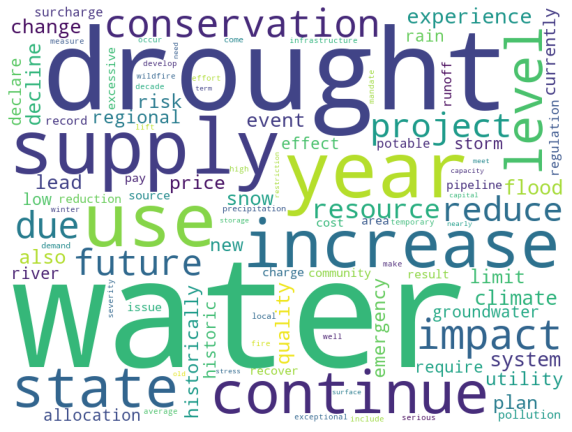

In [52]:
# import wordcloud 
from wordcloud import WordCloud, ImageColorGenerator

## Creating a wordcloud using top ranked 100 words 
fig, ax = plt.subplots(figsize=(10,10))
wc = WordCloud(background_color = 'white',
              width=800,height=600,
              max_words=2000).fit_words(top100words[:100])
plt.imshow(wc)
plt.axis("off")
#plt.savefig('result/snp_tf-idf.pdf')
plt.show()

Let's also generate the worldcloud for the bigram.

### Bigram wordcloud

In [156]:
top100bigram_df = fbigrams_list2.most_common(100)
top100bigram_df = pd.DataFrame(top100bigram_df)
top100bigram_df.columns = ['Words','Count']

#let's use the same process as the top20bigram dataframe to clean the top100bigram datafram 
top100bigram_df['Bigram'] = top100bigram_df['Words'].str[0] + ' ' + top100bigram_df['Words'].str[1]
top100bigram_df.drop('Words',axis=1, inplace=True)
top100bigram_df = top100bigram_df.set_index('Bigram')
top100bigram = top100bigram_df['Count']
top100bigram[:100]

Bigram
water supply        23
year drought        12
water use           12
water resource      11
continue decline     9
                    ..
drought rain         3
system lead          3
lead flood           3
flood impact         3
quality storm        3
Name: Count, Length: 100, dtype: int64

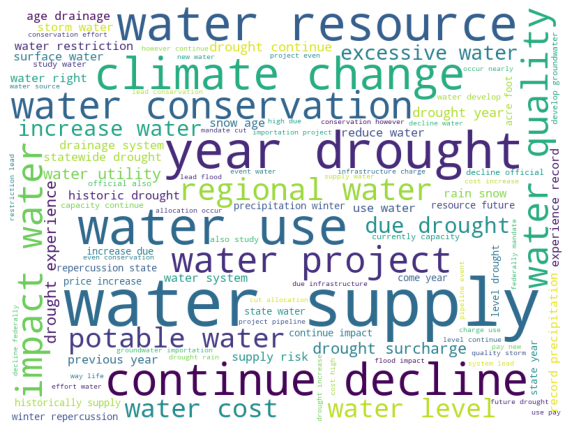

In [158]:
## Creating a wordcloud using top ranked 100 bigrams
fig, ax = plt.subplots(figsize=(10,10))
wc = WordCloud(background_color = 'white',
              width=800,height=600,
              max_words=2000,
              collocation_threshold = 3).fit_words(top100bigram[:100])
plt.imshow(wc)
plt.axis("off")
#plt.savefig('result/snp_tf-idf.pdf')
plt.show()

## LDA 

In [53]:
pd.DataFrame(top5["text_cleaned"])
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2))  

NameError: name 'CountVectorizer' is not defined

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

lda = LatentDirichletAllocation(n_components=2,random_state=0)

In [ ]:
n_top_words = 3
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,stop_words='english')

In [ ]:
tf_matrix = tf_vectorizer.fit_transform(doc_set)